# Fish classification using ResNet152

## setup

In [1]:
# import default libraries
import os
import glob
import shutil
import time
import argparse

In [2]:
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
# import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchnet.meter import AverageValueMeter, ClassErrorMeter

In [4]:
# global parameters
args = {
    "arch": "resnet152", # resnet50, resnet101, resnet152
    "pretrained": True,
    "datadir": "../data",
    "cuda": True,
    "optim": "adam", # sgd, adam, rmsprop
    "epochs": 100,
    "batch_size": 16,
    "lr": 1e-3,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "seed": 7,
    "workers": 4,
    "nb_augs": 10,
    "cv": 8
}
args = argparse.Namespace(**args)

In [5]:
args.cuda = args.cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [6]:
# data folders
traindir_full = os.path.join(args.datadir, "train")
testdir = os.path.join(args.datadir, "test_stg1")
# intermediate folder
intermediate_path = os.path.join("..", "intermediate")
submission_path = os.path.join(intermediate_path, "submissions")
if not os.path.isdir(submission_path):
    os.makedirs(submission_path)
# get classes
classes = sorted([x.split("/")[-1] for x in glob.glob(traindir_full+"/*")])

In [7]:
# split train/val cross validation
traindir = []
valdir = []

traindir_tmp = os.path.join(intermediate_path, "train_tmp")
g = glob.glob(traindir_full + "/*/*.jpg")
gg = ["/"+x.split("/")[-2]+"/"+x.split("/")[-1] for x in g]
np.random.seed(args.seed)
shuf = np.random.permutation(gg)
ticks = []
for i in range(args.cv):
    ticks.append(i * (len(gg)//args.cv))
ticks.append(len(gg))

for i in range(args.cv):
    traindir.append(os.path.join(intermediate_path, "train{}_{}".format(
        args.cv, str(i))))
    valdir.append(os.path.join(intermediate_path, "val{}_{}".format(
        args.cv, str(i))))
    if not os.path.isdir(traindir[i]):
        shutil.copytree(traindir_full, traindir[i])
    if not os.path.isdir(valdir[i]):
        vals = shuf[ticks[i]:ticks[i+1]]
        for val in vals:
            os.renames(traindir[i] + val, valdir[i] + val)

### utility functions

In [8]:
def save_checkpoint(state, is_best, modelbest_filepath,
                    filename="checkpoint.pth.tar"):
    checkpoint_filepath = os.path.join(intermediate_path, filename)
    torch.save(state, checkpoint_filepath)
    if is_best:
        shutil.copyfile(checkpoint_filepath, modelbest_filepath)

def adjust_learning_rate(args, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs
    """
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

### train/validate functions

In [9]:
# train function
def train(args, train_loader, model, criterion, optimizer, epoch):
    # turn on train mode
    model.train()
    losses = AverageValueMeter()
    top1 = ClassErrorMeter(accuracy=True) # accuracy instead of error
    
    for i, (input, target) in enumerate(train_loader):      
        # here we should call cuda() for input;
        # in the ImageNet example, the model is parallel by
        # torch.nn.DataParallel(model).cuda(), so no need to call cuda() there;
        # the option async=True works with pin_memory of DataLoader
        # pin_memory slows down DataLoader but fastens data transfer from
        # CPU to GPU
        if args.cuda:
            input = input.cuda()
            target = target.cuda()
        input_var = Variable(input)
        target_var = Variable(target)

        # compute output and loss
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.add(loss.data[0] * input.size(0), input.size(0))
        top1.add(output.data, target)

In [10]:
# validate function
def validate(args, val_loader, model, criterion, epoch):
    model.train(False) # turn off train mode
    losses = AverageValueMeter()
    top1 = ClassErrorMeter(accuracy=True)
    
    for i, (input, target) in enumerate(val_loader):
        if args.cuda:
            input = input.cuda(async=True)
            target = target.cuda(async=True)
        input_var = Variable(input, volatile=True) # no gradient
        target_var = Variable(target, volatile=True)
        output = model(input_var)
        loss = criterion(output, target_var)
        losses.add(loss.data[0] * input.size(0), input.size(0))
        top1.add(output.data, target)
        
    print("   * EPOCH {:>2} | Accuracy: {:.3f} | Loss: {:.4f}"
          .format(epoch, top1.value()[0], losses.value()[0]))
    return losses.value()[0]

### data loaders

In [11]:
def train_best(args, trainpath, valpath, modelbest_filename):
    # create model
    if args.pretrained:
        print("=> Using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
    else:
        print("=> Creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()
    for param in model.parameters():
        param.requires_grad = False
    # parameters of newly constructed modules have requires_grad=True by default
    # replace the last fully-connected layer
    model.fc = nn.Linear(2048, len(classes))
    # for 1 GPU, it is unnecessary to use DataParallel
    #model = torch.nn.DataParallel(model).cuda()
    if args.cuda:
        model.cuda()

    # define loss function
    criterion = nn.CrossEntropyLoss()
    if args.cuda:
        criterion.cuda()

    # define optimizer
    if args.optim == "sgd":
        optimizer = optim.SGD(model.fc.parameters(),
                              lr=args.lr,
                              momentum=args.momentum,
                              weight_decay=args.weight_decay)
    elif args.optim == "adam":
        optimizer = optim.Adam(model.fc.parameters(),
                               lr=args.lr,
                               weight_decay=args.weight_decay)
    elif args.optim == "rmsprop":
        optimizer = optim.RMSprop(model.fc.parameters(),
                                  lr=args.lr,
                                  weight_decay=args.weight_decay)

    # Data loading code
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_loader = DataLoader(
        datasets.ImageFolder(trainpath,
                             transforms.Compose([
                                 transforms.Scale(400),
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize])),
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
    )

    val_loader = DataLoader(
        datasets.ImageFolder(valpath,
                             transforms.Compose([
                                 transforms.Scale(400),
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize])),
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
    )
    
    # best model path
    modelbest_filepath = os.path.join(intermediate_path, modelbest_filename)

    print("=> Starting to train on '{}' model".format(args.arch))
    best_loss = 2
    for epoch in range(1, args.epochs+1):
        start = time.time()
        adjust_learning_rate(args, optimizer, epoch)

        # train for one epoch
        train(args, train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        loss = validate(args, val_loader, model, criterion, epoch)

        # remember best loss and save checkpoint
        is_best = loss < best_loss
        best_loss = min(loss, best_loss)
        save_checkpoint({
            "epoch": epoch,
            "arch": args.arch,
            "state_dict": model.state_dict(),
            "best_loss": best_loss,
        }, is_best, modelbest_filepath)
        print("   => Time: {}s".format(round(time.time()-start)))
    return modelbest_filepath

In [12]:
model_filepaths = []
for i in range(args.cv):
    modelbest_filename = "{}_cv{}_b{}_best{}.pth.tar".format(
        args.arch, args.cv, args.batch_size, i)
    best = train_best(args, traindir[i], valdir[i], modelbest_filename)
    model_filepaths.append(best)

=> Using pre-trained model 'resnet152'
=> Starting to train on 'resnet152' model
   * EPOCH  1 | Accuracy: 61.864 | Loss: 1.0869
   => Time: 61s
   * EPOCH  2 | Accuracy: 59.534 | Loss: 1.1313
   => Time: 43s
   * EPOCH  3 | Accuracy: 62.076 | Loss: 1.0864
   => Time: 44s
   * EPOCH  4 | Accuracy: 64.619 | Loss: 1.0157
   => Time: 45s
   * EPOCH  5 | Accuracy: 67.585 | Loss: 1.0248
   => Time: 42s
   * EPOCH  6 | Accuracy: 61.441 | Loss: 1.0382
   => Time: 43s
   * EPOCH  7 | Accuracy: 66.949 | Loss: 0.9382
   => Time: 44s
   * EPOCH  8 | Accuracy: 69.068 | Loss: 0.8866
   => Time: 44s
   * EPOCH  9 | Accuracy: 71.398 | Loss: 0.8267
   => Time: 44s
   * EPOCH 10 | Accuracy: 62.712 | Loss: 1.0595
   => Time: 42s
   * EPOCH 11 | Accuracy: 65.254 | Loss: 0.9537
   => Time: 42s
   * EPOCH 12 | Accuracy: 70.975 | Loss: 0.8021
   => Time: 45s
   * EPOCH 13 | Accuracy: 70.127 | Loss: 0.9456
   => Time: 42s
   * EPOCH 14 | Accuracy: 67.373 | Loss: 0.9020
   => Time: 43s
   * EPOCH 15 | Accurac

## Submit

In [13]:
class TestImageFolder(Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filepath in sorted(glob.glob(root + "/*.jpg")):
            images.append(filepath.split("/")[-1])

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_loader = DataLoader(
    TestImageFolder(testdir, 
                    transforms.Compose([
                        transforms.Scale(400),
                        transforms.RandomSizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize])),
    batch_size=1,
    shuffle=False,
    num_workers=args.workers,
)

In [15]:
def test(args, test_loader, model):
    # placeholder arrays for predictions and id column
    preds = np.zeros(shape=(len(test_loader), len(classes)))
    id_col = []
    
    # turn off train mode
    model.train(False)
    
    # average predictions across several different augmentations
    for aug in range(args.nb_augs):
        print("   * Predicting on test augmentation {}".format(aug + 1))
        
        # iterate through image data, one file at a time
        # (assuming batch size set to 1)
        for i, (input, filename) in enumerate(test_loader):
            # batch_size = 1
            filename = filename[0]
                     
            if args.cuda:
                input = input.cuda()
            input_var = Variable(input, volatile=True) # no gradient
            output = model(input_var)
            softmax = F.softmax(output)[0].data.cpu().numpy()
            
            # add the scaled class probabilities
            preds[i] += softmax
            if aug == 0:
                id_col.append(filename)
       
    # convert averaged prediction array to pandas dataframe
    preds /= args.nb_augs
    return preds, id_col

In [16]:
def test_ensemble(args, test_loader, model, model_filepaths):
    preds = np.zeros(shape=(len(test_loader), len(classes)))
    for model_filepath in model_filepaths:
        if os.path.isfile(model_filepath):
            print("=> Loading checkpoint '{}'".format(model_filepath))
            checkpoint = torch.load(model_filepath)
            model.load_state_dict(checkpoint["state_dict"])
            print("=> Loaded checkpoint '{}' (epoch {}, loss {})"
                  .format(model_filepath, checkpoint["epoch"],
                          checkpoint["best_loss"]))
            pred, id_col = test(args, test_loader, model)
            preds += pred
        else:
            print("=> No checkpoint found at '{}'".format(model_filepath))
            return None
    preds /= len(model_filepaths)
    pred_df = pd.DataFrame(preds, columns=[classes])
    pred_df["image"] = id_col
    return pred_df

In [17]:
print("=> Starting to test on '{}' model".format(args.arch))
# create model
if args.pretrained:
    model = models.__dict__[args.arch](pretrained=True)
else:
    model = models.__dict__[args.arch]()
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, len(classes))
if args.cuda:
    model.cuda()
pred_df = test_ensemble(args, test_loader, model, model_filepaths)

=> Starting to test on 'resnet152' model
=> Loading checkpoint '../intermediate/resnet152_cv8_b16_best0.pth.tar'
=> Loaded checkpoint '../intermediate/resnet152_cv8_b16_best0.pth.tar' (epoch 63, loss 0.6652075572539184)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting on test augmentation 6
   * Predicting on test augmentation 7
   * Predicting on test augmentation 8
   * Predicting on test augmentation 9
   * Predicting on test augmentation 10
=> Loading checkpoint '../intermediate/resnet152_cv8_b16_best1.pth.tar'
=> Loaded checkpoint '../intermediate/resnet152_cv8_b16_best1.pth.tar' (epoch 62, loss 0.6558186881623026)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting

In [18]:
# write predictions to csv
if pred_df is not None:
    sub_fn = "{}_cv{}_b{}.csv".format(
        args.arch, args.cv, args.batch_size)
    pred_df.to_csv(os.path.join(submission_path, sub_fn), index=False)
del model

## confusion matrix

In [19]:
# validate function
def predict(args, data_loader, model, criterion, epoch):
    model.train(False) # turn off train mode
    losses = AverageValueMeter()
    top1 = ClassErrorMeter(accuracy=True)
    
    for i, (input, target) in enumerate(data_loader):
        if args.cuda:
            input = input.cuda(async=True)
            target = target.cuda(async=True)
        input_var = Variable(input, volatile=True) # no gradient
        target_var = Variable(target, volatile=True)
        output = model(input_var)
        loss = criterion(output, target_var)
        losses.add(loss.data[0] * input.size(0), input.size(0))
        top1.add(output.data, target)
        
    print("   * EPOCH {:>2} | Accuracy: {:.3f} | Loss: {:.4f}"
          .format(epoch, top1.value()[0], losses.value()[0]))
    return losses.value()[0]

In [20]:
data_loader = DataLoader(
        datasets.ImageFolder(traindir_full,
                             transforms.Compose([
                                 transforms.Scale(400),
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize])),
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
    )

In [21]:
g = glob.glob(traindir_full + "/*/*.jpg")
t = dict()
for file in g:
    t[file.split("/")[-1]] = file.split("/")[-2]
t = pd.DataFrame.from_dict(t, orient="index").sort_index()
t.columns = ["label"]

In [22]:
datadir = os.path.join(intermediate_path, "fulldata")

In [23]:
if not os.path.isdir(datadir):
    os.makedirs(datadir)

In [24]:
for file in g:
    shutil.copy(file, datadir)

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_loader = DataLoader(
    TestImageFolder(datadir, 
                    transforms.Compose([
                        transforms.Scale(400),
                        transforms.RandomSizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize])),
    batch_size=1,
    shuffle=False,
    num_workers=args.workers,
)

In [ ]:
print("=> Starting to test on '{}' model".format(args.arch))
# create model
if args.pretrained:
    model = models.__dict__[args.arch](pretrained=True)
else:
    model = models.__dict__[args.arch]()
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, len(classes))
if args.cuda:
    model.cuda()
# model_filepaths = ['../intermediate/resnet101_cv5_b16_best0.pth.tar',
#                    '../intermediate/resnet101_cv5_b16_best1.pth.tar',
#                    '../intermediate/resnet101_cv5_b16_best2.pth.tar',
#                    '../intermediate/resnet101_cv5_b16_best3.pth.tar',
#                    '../intermediate/resnet101_cv5_b16_best4.pth.tar']
pred_df = test_ensemble(args, data_loader, model, model_filepaths)

=> Starting to test on 'resnet152' model
=> Loading checkpoint '../intermediate/resnet152_cv8_b16_best0.pth.tar'
=> Loaded checkpoint '../intermediate/resnet152_cv8_b16_best0.pth.tar' (epoch 63, loss 0.6652075572539184)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting on test augmentation 6
   * Predicting on test augmentation 7
   * Predicting on test augmentation 8
   * Predicting on test augmentation 9
   * Predicting on test augmentation 10
=> Loading checkpoint '../intermediate/resnet152_cv8_b16_best1.pth.tar'
=> Loaded checkpoint '../intermediate/resnet152_cv8_b16_best1.pth.tar' (epoch 62, loss 0.6558186881623026)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
   * Predicting on test augmentation 3
   * Predicting on test augmentation 4
   * Predicting on test augmentation 5
   * Predicting

In [34]:
p = pd.DataFrame(pred_df.set_index("image").idxmax(axis=1).sort_index())
p.columns = ["label"]
p.index.name = None

In [35]:
dict_classes = {x[1]: x[0] for x in enumerate(classes)}

In [36]:
tt = [dict_classes[x] for x in t["label"].values]
pp = [dict_classes[x] for x in p["label"].values]

             precision    recall  f1-score   support

        ALB       0.81      0.96      0.88      1719
        BET       0.88      0.63      0.73       200
        DOL       0.80      0.83      0.82       117
        LAG       1.00      0.99      0.99        67
        NoF       0.97      0.78      0.87       465
      OTHER       0.91      0.75      0.82       299
      SHARK       0.91      0.97      0.94       176
        YFT       0.88      0.73      0.80       734

avg / total       0.86      0.86      0.85      3777



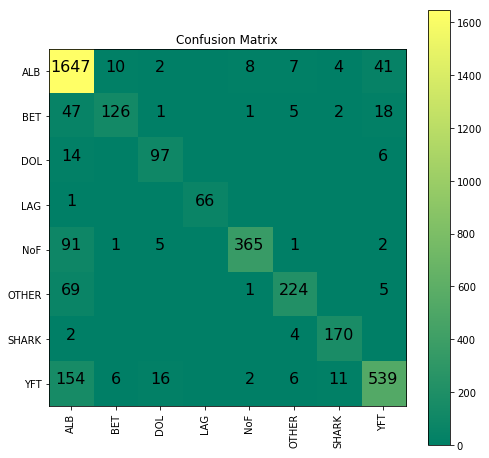

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

print(classification_report(tt, pp,
                            target_names=classes))

conf_mat = confusion_matrix(tt, pp)

fig = plt.figure(figsize=(8,8))
width = conf_mat.shape[1]
height = conf_mat.shape[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c > 0:
            plt.text(j , i, c, horizontalalignment="center", fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(8), classes, rotation=90)
_ = plt.yticks(range(8), classes)

In [38]:
import pickle

In [39]:
with open("../intermediate/resnet152_prediction.pkl", "wb") as f:
    pickle.dump((t, p, pred_df), f, pickle.HIGHEST_PROTOCOL)

In [40]:
with open("../intermediate/resnet152_prediction.pkl", "rb") as f:
    t1, p1, pred_df1 =  pickle.load(f)

In [73]:
pred_df1.set_index("image").loc[t1[(t1["label"] != p1["label"]) & (t1["label"] == "SHARK")].index]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_02271.jpg,0.159961,0.025183,0.001199,0.000104,0.006698,0.474273,0.058976,0.273606
img_04131.jpg,0.167234,0.027533,0.000357,0.000108,0.005771,0.426788,0.070585,0.301625
img_05685.jpg,0.189599,0.032845,0.000720,0.000304,0.007275,0.415732,0.058164,0.295362
img_05942.jpg,0.124096,0.027714,0.000351,0.000367,0.006940,0.571836,0.047188,0.221508
img_06006.jpg,0.526943,0.287085,0.040153,0.002802,0.006354,0.026889,0.004351,0.105422
img_06082.jpg,0.701710,0.056445,0.003191,0.019982,0.021256,0.101674,0.010896,0.084845


In [77]:
pred_df1.set_index("image").loc[t1[(t1["label"] != p1["label"]) & (t1["label"] == "BET")].index]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_00379.jpg,0.395713,0.016171,0.004252,0.047692,0.368396,0.110072,0.002979,0.054726
img_00435.jpg,0.603494,0.167979,0.005680,0.001985,0.003047,0.079044,0.000596,0.138175
img_00491.jpg,0.408152,0.353464,0.000670,0.054282,0.069568,0.081962,0.000698,0.031204
img_00531.jpg,0.063676,0.272453,0.053974,0.000451,0.012240,0.009484,0.000616,0.587106
img_00883.jpg,0.465342,0.120209,0.000404,0.000881,0.007259,0.104696,0.067466,0.233744
img_01118.jpg,0.143321,0.027097,0.003027,0.000082,0.460373,0.053714,0.000496,0.311890
img_01166.jpg,0.469974,0.336881,0.005936,0.000753,0.025655,0.009244,0.005386,0.146171
img_01215.jpg,0.306556,0.208700,0.009192,0.003803,0.071641,0.136666,0.002602,0.260839
img_01299.jpg,0.041001,0.035562,0.391090,0.000368,0.012277,0.002765,0.001889,0.515048
img_01450.jpg,0.088803,0.304980,0.078712,0.000483,0.019770,0.013894,0.000605,0.492755


In [71]:
pred_df1.set_index("image").loc[t1[(t1["label"] != p1["label"]) & (t1["label"] == "LAG")].index]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_07817.jpg,0.869566,0.01673,0.004796,0.044627,0.018501,0.021739,0.000274,0.023767


In [74]:
pred_df1.set_index("image").loc[t1[(t1["label"] != p1["label"]) & (t1["label"] == "DOL")].index]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_00165.jpg,0.574717,0.031825,0.237246,0.007847,0.030876,0.056571,0.000714,0.060203
img_01311.jpg,0.520977,0.065573,0.217117,0.009072,0.035538,0.083177,0.001441,0.067104
img_01471.jpg,0.056272,0.015766,0.366781,0.000288,0.024903,0.017368,0.001165,0.517457
img_01757.jpg,0.638906,0.061735,0.130400,0.005148,0.028785,0.078134,0.000101,0.056791
img_01812.jpg,0.372514,0.035319,0.372362,0.005681,0.022276,0.098504,0.000814,0.092531
img_02100.jpg,0.632069,0.041884,0.131085,0.004509,0.016551,0.116094,0.000265,0.057544
img_02333.jpg,0.056499,0.028042,0.314321,0.000105,0.008546,0.021979,0.000493,0.570014
img_02798.jpg,0.145158,0.045632,0.279840,0.003301,0.036706,0.052965,0.003700,0.432697
img_04676.jpg,0.063606,0.028433,0.372511,0.000140,0.026750,0.017522,0.000496,0.490543
img_04824.jpg,0.419283,0.061777,0.325979,0.008111,0.020039,0.062972,0.002510,0.099330


In [76]:
pred_df1.set_index("image").loc[t1[(t1["label"] != p1["label"]) & (t1["label"] == "ALB") & (p1["label"] != "YFT")].index]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_00136.jpg,0.269772,0.311739,0.000396,0.005435,0.026962,0.007731,0.345697,0.032268
img_00248.jpg,0.255272,0.370278,0.000117,0.002284,0.008642,0.006702,0.322051,0.034654
img_00288.jpg,0.228087,0.061502,0.000918,0.000043,0.011681,0.133718,0.355709,0.208342
img_00351.jpg,0.234675,0.017929,0.008389,0.000046,0.004263,0.414202,0.047530,0.272966
img_00361.jpg,0.328094,0.434292,0.005640,0.002344,0.124282,0.008169,0.004470,0.092709
img_00366.jpg,0.207232,0.015984,0.003724,0.007631,0.458124,0.081228,0.002846,0.223232
img_01300.jpg,0.266856,0.024503,0.004301,0.000449,0.008790,0.316010,0.101391,0.277699
img_01363.jpg,0.283923,0.374032,0.000179,0.003815,0.016936,0.006555,0.280258,0.034302
img_01654.jpg,0.132141,0.008131,0.583581,0.000300,0.032804,0.087141,0.010772,0.145129
img_01738.jpg,0.135408,0.003183,0.000491,0.000370,0.838679,0.008777,0.005606,0.007486
